In [81]:
!pip install optuna
import optuna
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [76]:
# 테이터 확인
df_train = pd.read_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/train.csv')
df_train

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,TRAIN_00000,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,TRAIN_00001,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,TRAIN_00002,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,TRAIN_00003,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,TRAIN_00004,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,TRAIN_09995,주택 담보 대출 (거주 중),1339473.0,10년 이상,0.0,9,18.7,319027.5,0,68,0,부채 통합,단기 상환,126216.0,177028.5,6237.0,755,0
9996,TRAIN_09996,주택 담보 대출 (거주 중),2297230.5,2년,0.0,11,28.3,399799.5,0,7,0,주택 개보수,장기 상환,371907.0,347449.5,53301.0,707,0
9997,TRAIN_09997,주택 담보 대출 (거주 중),1221523.5,10년 이상,0.0,9,30.1,823305.0,0,14,0,부채 통합,장기 상환,869736.0,176905.5,11436.0,733,0
9998,TRAIN_09998,자가,3343584.0,10년 이상,0.0,10,20.3,724314.0,0,25,0,부채 통합,단기 상환,443008.5,139294.5,25567.5,696,0


In [77]:
# 결측치가 없음을 확인
# object 데이터 LabelEncoding 변환
encoding_list = list(df_train.columns)
encoding_list = encoding_list[1:2] + encoding_list[3:4] + encoding_list[11:13]

encoder = LabelEncoder()
for i in encoding_list:
  encoder.fit(df_train[i])
  df_train[i] = encoder.transform(df_train[i])

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                10000 non-null  object 
 1   주거 형태              10000 non-null  int64  
 2   연간 소득              10000 non-null  float64
 3   현재 직장 근속 연수        10000 non-null  int64  
 4   체납 세금 압류 횟수        10000 non-null  float64
 5   개설된 신용계좌 수         10000 non-null  int64  
 6   신용 거래 연수           10000 non-null  float64
 7   최대 신용한도            10000 non-null  float64
 8   신용 문제 발생 횟수        10000 non-null  int64  
 9   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 10  개인 파산 횟수           10000 non-null  int64  
 11  대출 목적              10000 non-null  int64  
 12  대출 상환 기간           10000 non-null  int64  
 13  현재 대출 잔액           10000 non-null  float64
 14  현재 미상환 신용액         10000 non-null  float64
 15  월 상환 부채액           10000 non-null  float64
 16  신용 점수              1000

In [78]:
# UID열 제거
df_train.drop(columns = ['UID'], inplace = True)

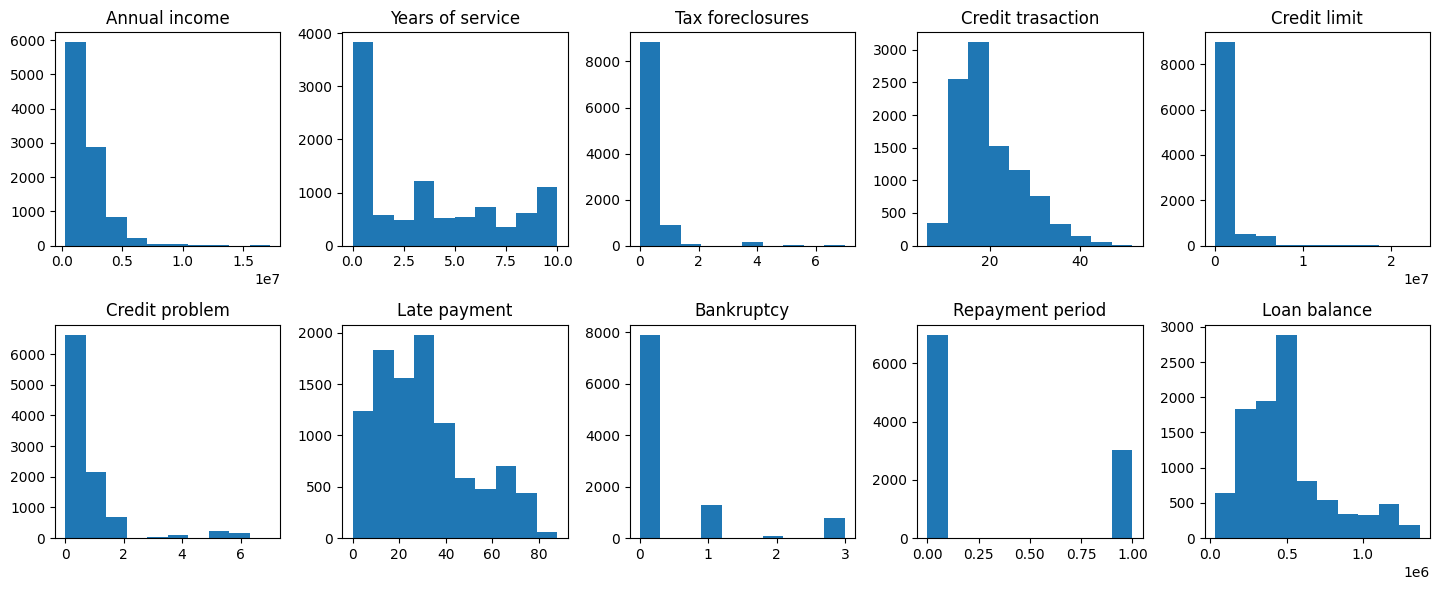

In [79]:
# 각 데이터별 boxplot 시각화
fig, axes = plt.subplots(2, 5, figsize = (14.5, 6))

axes[0,0].hist(df_train['연간 소득'])
axes[0,0].set_title('Annual income')

axes[0,1].hist(df_train['현재 직장 근속 연수'])
axes[0,1].set_title('Years of service')

axes[0,2].hist(df_train['체납 세금 압류 횟수'])
axes[0,2].set_title('Tax foreclosures')

axes[0,3].hist(df_train['신용 거래 연수'])
axes[0,3].set_title('Credit trasaction')

axes[0,4].hist(df_train['최대 신용한도'])
axes[0,4].set_title('Credit limit')

axes[1,0].hist(df_train['신용 문제 발생 횟수'])
axes[1,0].set_title('Credit problem')

axes[1,1].hist(df_train['마지막 연체 이후 경과 개월 수'])
axes[1,1].set_title('Late payment')

axes[1,2].hist(df_train['개인 파산 횟수'])
axes[1,2].set_title('Bankruptcy')

axes[1,3].hist(df_train['대출 상환 기간'])
axes[1,3].set_title('Repayment period')

axes[1,4].hist(df_train['현재 대출 잔액'])
axes[1,4].set_title('Loan balance')

plt.tight_layout()
plt.show()

# 데이터 불균형 확인

In [80]:
# 데이터 이상치 제거
df_train.drop(index = df_train[df_train['연간 소득'] >= 15000000].index, inplace = True)
df_train.drop(index = df_train[df_train['개설된 신용계좌 수'] >= 35].index, inplace = True)
df_train.drop(index = df_train[df_train['신용 거래 연수'] >= 50].index, inplace = True)
df_train.drop(index = df_train[df_train['최대 신용한도'] >= 19000000].index, inplace = True)
df_train.drop(index = df_train[df_train['월 상환 부채액'] >= 140000].index, inplace = True)

# 총 10개 행 제거

In [82]:
# 데이터 왜곡을 최소화하기 위한 로그변환
df_train['연간 소득'] = np.log1p(df_train['연간 소득'])
df_train['체납 세금 압류 횟수'] = np.log1p(df_train['체납 세금 압류 횟수'])
df_train['최대 신용한도'] = np.log1p(df_train['최대 신용한도'])
df_train['현재 대출 잔액'] = np.log1p(df_train['현재 대출 잔액'])
df_train['현재 미상환 신용액'] = np.log1p(df_train['현재 미상환 신용액'])
df_train['월 상환 부채액'] = np.log1p(df_train['월 상환 부채액'])
df_train['개설된 신용계좌 수'] = np.log1p(df_train['개설된 신용계좌 수'])
df_train['신용 거래 연수'] = np.log1p(df_train['신용 거래 연수'])

In [83]:
# Optuna를 사용하기 위한 모델 정의
def prediction_model(trial):
  x = df_train.drop(columns = ['채무 불이행 여부'])
  y = df_train['채무 불이행 여부']

  # 데이터 분할
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

  # 데이터 불균형을 해소하기 위한 언더샘플링
  rus = RandomUnderSampler(random_state = 42)
  x_resampled, y_resampled = rus.fit_resample(x_train, y_train)

  # optuna에 사용할 하이퍼파라미터 설정
  params = {
      'objective':'binary:logistic',
      'n_estimators':trial.suggest_int('n_estimators', 100, 5000),
      'learning_rate':trial.suggest_float('learning_rate', 1e-3, 3e-1, log = True),
      'max_depth':trial.suggest_int('max_depth', 3, 15),
      'min_child_weight':trial.suggest_int('min_child_weight', 1, 10),
      'reg_alpha':trial.suggest_int('reg_alpha', 0, 10),
      'random_state':42
  }

  # 로지스틱 회귀모델 객체 생성
  xgb_cls = XGBClassifier(**params)
  xgb_cls.fit(x_train, y_train)

  # 예측값 도출
  y_pred = xgb_cls.predict(x_test)
  score = roc_auc_score(y_test, y_pred)

  return score

In [84]:
# prediction_model의 최적 하이퍼파라미터 찾기
study = optuna.create_study(direction = 'maximize')
study.optimize(prediction_model, n_trials = 200)

optimum_params = study.best_params
print(optimum_params)

[I 2025-03-20 06:13:41,302] A new study created in memory with name: no-name-5dc5f068-fb30-459d-aad0-0fa428a4fc24
[I 2025-03-20 06:13:59,268] Trial 0 finished with value: 0.6444077585207352 and parameters: {'n_estimators': 3475, 'learning_rate': 0.001136843593872127, 'max_depth': 14, 'min_child_weight': 10, 'reg_alpha': 10}. Best is trial 0 with value: 0.6444077585207352.
[I 2025-03-20 06:14:17,699] Trial 1 finished with value: 0.647763600324652 and parameters: {'n_estimators': 2340, 'learning_rate': 0.006637734981083028, 'max_depth': 14, 'min_child_weight': 6, 'reg_alpha': 4}. Best is trial 1 with value: 0.647763600324652.
[I 2025-03-20 06:14:26,151] Trial 2 finished with value: 0.6683878376960749 and parameters: {'n_estimators': 4958, 'learning_rate': 0.004449830654241458, 'max_depth': 3, 'min_child_weight': 1, 'reg_alpha': 9}. Best is trial 2 with value: 0.6683878376960749.
[I 2025-03-20 06:14:28,538] Trial 3 finished with value: 0.6551980211686369 and parameters: {'n_estimators': 9

{'n_estimators': 1681, 'learning_rate': 0.029727915588572778, 'max_depth': 5, 'min_child_weight': 2, 'reg_alpha': 10}


In [85]:
# test 데이터 불러오기
df_test = pd.read_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/test.csv')

# test 데이터 확인
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                2062 non-null   object 
 1   주거 형태              2062 non-null   object 
 2   연간 소득              2062 non-null   float64
 3   현재 직장 근속 연수        2062 non-null   object 
 4   체납 세금 압류 횟수        2062 non-null   float64
 5   개설된 신용계좌 수         2062 non-null   int64  
 6   신용 거래 연수           2062 non-null   float64
 7   최대 신용한도            2062 non-null   float64
 8   신용 문제 발생 횟수        2062 non-null   int64  
 9   마지막 연체 이후 경과 개월 수  2062 non-null   int64  
 10  개인 파산 횟수           2062 non-null   int64  
 11  대출 목적              2062 non-null   object 
 12  대출 상환 기간           2062 non-null   object 
 13  현재 대출 잔액           2062 non-null   float64
 14  현재 미상환 신용액         2062 non-null   float64
 15  월 상환 부채액           2062 non-null   float64
 16  신용 점수              2062 

In [86]:
# train 데이터 중 object 데이터 LabelEncoding 변환
test_column_list = list(df_test.columns)
test_column_list = test_column_list[1:2] + test_column_list[3:4] + test_column_list[11:13]

encoder = LabelEncoder()
for i in test_column_list:
  encoder.fit(df_test[i])
  df_test[i] = encoder.transform(df_test[i])

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   UID                2062 non-null   object 
 1   주거 형태              2062 non-null   int64  
 2   연간 소득              2062 non-null   float64
 3   현재 직장 근속 연수        2062 non-null   int64  
 4   체납 세금 압류 횟수        2062 non-null   float64
 5   개설된 신용계좌 수         2062 non-null   int64  
 6   신용 거래 연수           2062 non-null   float64
 7   최대 신용한도            2062 non-null   float64
 8   신용 문제 발생 횟수        2062 non-null   int64  
 9   마지막 연체 이후 경과 개월 수  2062 non-null   int64  
 10  개인 파산 횟수           2062 non-null   int64  
 11  대출 목적              2062 non-null   int64  
 12  대출 상환 기간           2062 non-null   int64  
 13  현재 대출 잔액           2062 non-null   float64
 14  현재 미상환 신용액         2062 non-null   float64
 15  월 상환 부채액           2062 non-null   float64
 16  신용 점수              2062 

In [87]:
# 데이터 왜곡을 최소화하기 위한 로그변환
df_test['연간 소득'] = np.log1p(df_test['연간 소득'])
df_test['체납 세금 압류 횟수'] = np.log1p(df_test['체납 세금 압류 횟수'])
df_test['최대 신용한도'] = np.log1p(df_test['최대 신용한도'])
df_test['현재 대출 잔액'] = np.log1p(df_test['현재 대출 잔액'])
df_test['현재 미상환 신용액'] = np.log1p(df_test['현재 미상환 신용액'])
df_test['월 상환 부채액'] = np.log1p(df_test['월 상환 부채액'])
df_test['개설된 신용계좌 수'] = np.log1p(df_test['개설된 신용계좌 수'])
df_test['신용 거래 연수'] = np.log1p(df_test['신용 거래 연수'])

In [88]:
# 최적 하이퍼파라미터를 이용한 객체 생성
xgb_cls = XGBClassifier(**optimum_params)

# 먼저 train 데이터를 통해 모델학습
x = df_train.drop(columns = ['채무 불이행 여부'])
y = df_train['채무 불이행 여부']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

xgb_cls.fit(x_train, y_train)

# 최적 하이퍼파라미터를 이용한 학습모델에 test 데이터를 반영하여 채무 불이행 여부 도출
x = df_test.drop(columns = ['UID'])
y_default = xgb_cls.predict(x)

df_trial = pd.DataFrame({'UID':df_test['UID'], '채무 불이행 확률':y_default})
df_trial

,UID,채무 불이행 확률
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,0
4,TEST_0004,0
...,...,...
2057,TEST_2057,0
2058,TEST_2058,0
2059,TEST_2059,0
2060,TEST_2060,0


In [89]:
df_trial.to_csv('/content/drive/MyDrive/DACON/채무 불이행 여부 예측 해커톤: 불이행의 징후를 찾아라!/submission_0320.csv', encoding = 'UTF-8-sig', index = False)
print('✅제출 파일이 저장되었습니다.')

✅제출 파일이 저장되었습니다.
